# Data Creation

In [1]:
# important libraries
import pickle
import pandas as pd
import re
from collections import Counter

# data preprocessing
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# alt.renderers.enable("notebook")
import warnings
warnings.filterwarnings("ignore")

## Dataset Sources

* https://github.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset

In [2]:
df = pd.read_csv('datasets/Twitter_Emotion_Dataset.csv')
df

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m..."
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ..."
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...


In [3]:
df['label'].value_counts()

anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: label, dtype: int64

In [4]:
# switch column position

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [5]:
df

,tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",anger
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",anger
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,happy
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",anger
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",happy
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",love
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,fear
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",anger
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,happy


## Data Preprocessing

### Remove Special Characters

In [6]:
df['cleaned_1'] = df['tweet'].str.replace('\W', ' ')

### Remove Punctuations

In [7]:
df["cleaned_2"] = df['cleaned_1'].str.replace('[^\w\s]','')

### Remove Unnecessary Strings
List of Strings: "username", "url", "sensitive-no"

In [8]:
def remove_unnecesary_strings(data, word):
    data = data.str.replace(' '+str(word), '')
    data = data.str.replace(str(word)+' ', '')
    data = data.str.replace(' '+str(word)+' ', '')
    return data

In [9]:
df['cleaned_3'] = remove_unnecesary_strings(df['cleaned_2'], 'username')
df['cleaned_3'] = remove_unnecesary_strings(df['cleaned_3'], 'url')
df['cleaned_3'] = remove_unnecesary_strings(df['cleaned_3'], 'sensitive-no')

### Indonesian Word Lemmatization or Word Stemming

In [10]:
# lematisasi kata menjadi kata dasar dengan menghilangkan imbuhannya
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def lemmatize_words(tweets):
    nrows = len(tweets)
    lemmatized_text_list = []
    
    for row in range(0, nrows):
        list_of_words = []
        words = stemmer.stem(tweets)
        list_of_words.append(words)
    
    lemmatized_text = " ".join(list_of_words)
    lemmatized_text_list.append(lemmatized_text)
    
    return lemmatized_text_list

In [11]:
df['cleaned_4'] = df['cleaned_3'].apply(lemmatize_words)
df['cleaned_4'] = df['cleaned_4'].str[0]

### Remove Indonesian Stopwords

In [12]:
stop_words = pd.read_csv('datasets/stopwords-id.txt', names=['stopwords'], header=None)

def stopwords(tweets):
    for stop_word in stop_words:
        regex_stopword = r"\b" + stop_word + r"\b"
        tweets = tweets.replace(regex_stopword, '')
    return tweets

In [13]:
df['cleaned_5'] = df['cleaned_4'].apply(stopwords)

### Get Tweet Length

In [14]:
def get_length(df):
    length = []
    for i in range(len(df)):
        length.append(len(df[i].split()))
    return length

df['tweets_length'] = get_length(df['cleaned_5'])

In [15]:
df

,tweet,label,cleaned_1,cleaned_2,cleaned_3,cleaned_4,cleaned_5,tweets_length
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",anger,Soal jln Jatibaru polisi tdk bs GERTAK gubernu...,Soal jln Jatibaru polisi tdk bs GERTAK gubernu...,Soal jln Jatibaru polisi tdk bs GERTAK gubernu...,soal jln jatibaru polisi tdk bs gertak gubernu...,soal jln jatibaru polisi tdk bs gertak gubernu...,31
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",anger,Sesama cewe lho kayaknya harusnya bisa lebi...,Sesama cewe lho kayaknya harusnya bisa lebi...,Sesama cewe lho kayaknya harusnya bisa lebi...,sama cewe lho kayak harus bisa lebih rasain la...,sama cewe lho kayak harus bisa lebih rasain la...,35
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,happy,Kepingin gudeg mbarek Bu hj Amad Foto dari go...,Kepingin gudeg mbarek Bu hj Amad Foto dari go...,Kepingin gudeg mbarek Bu hj Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto dari goo...,18
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",anger,Jln Jatibaru bagian dari wilayah Tn Abang Peng...,Jln Jatibaru bagian dari wilayah Tn Abang Peng...,Jln Jatibaru bagian dari wilayah Tn Abang Peng...,jln jatibaru bagi dari wilayah tn abang atur w...,jln jatibaru bagi dari wilayah tn abang atur w...,41
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",happy,Sharing pengalaman aja kemarin jam 18 00 bata...,Sharing pengalaman aja kemarin jam 18 00 bata...,Sharing pengalaman aja kemarin jam 18 00 bata...,sharing alam aja kemarin jam 18 00 batalin tik...,sharing alam aja kemarin jam 18 00 batalin tik...,33
...,...,...,...,...,...,...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",love,Tahukah kamu bahwa saat itu papa memejamkan m...,Tahukah kamu bahwa saat itu papa memejamkan m...,Tahukah kamu bahwa saat itu papa memejamkan m...,tahu kamu bahwa saat itu papa mejam mata dan t...,tahu kamu bahwa saat itu papa mejam mata dan t...,25
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulit tetap calon wapresnya jokowi di pilpres ...,sulit tetap calon wapresnya jokowi di pilpres ...,36
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",anger,5 masa depannya nggak jelas lha iya gimana ...,5 masa depannya nggak jelas lha iya gimana ...,5 masa depannya nggak jelas lha iya gimana ...,5 masa depan nggak jelas lha iya gimana mau je...,5 masa depan nggak jelas lha iya gimana mau je...,31
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,happy,USERNAME dulu beneran ada mahasiswa Teknik U...,USERNAME dulu beneran ada mahasiswa Teknik U...,USERNAME dulu beneran ada mahasiswa Teknik U...,username dulu beneran ada mahasiswa teknik ui ...,username dulu beneran ada mahasiswa teknik ui ...,36


In [16]:
# df.to_csv('datasets/df_comparisons.csv')

In [17]:
list_columns = ["label", "tweet", "tweets_length", "cleaned_5"]
df = df[list_columns]

df.rename(columns={'cleaned_5': 'cleaned_tweets'}, inplace=True)
df

,label,tweet,tweets_length,cleaned_tweets
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",31,soal jln jatibaru polisi tdk bs gertak gubernu...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",35,sama cewe lho kayak harus bisa lebih rasain la...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,18,kepingin gudeg mbarek bu hj amad foto dari goo...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",41,jln jatibaru bagi dari wilayah tn abang atur w...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",33,sharing alam aja kemarin jam 18 00 batalin tik...
...,...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",25,tahu kamu bahwa saat itu papa mejam mata dan t...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,36,sulit tetap calon wapresnya jokowi di pilpres ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",31,5 masa depan nggak jelas lha iya gimana mau je...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,36,username dulu beneran ada mahasiswa teknik ui ...


## Label Encoding

In [18]:
df['label'].unique()

array(['anger', 'happy', 'sadness', 'love', 'fear'], dtype=object)

In [19]:
# Category mapping
label_codes = {
    'anger': 0,
    'happy': 1,
    'sadness': 2,
    'love': 3,
    'fear': 4
}

df['label_code'] = df['label']
df = df.replace({'label_code':label_codes})

In [20]:
df

,label,tweet,tweets_length,cleaned_tweets,label_code
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",31,soal jln jatibaru polisi tdk bs gertak gubernu...,0
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",35,sama cewe lho kayak harus bisa lebih rasain la...,0
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,18,kepingin gudeg mbarek bu hj amad foto dari goo...,1
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",41,jln jatibaru bagi dari wilayah tn abang atur w...,0
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",33,sharing alam aja kemarin jam 18 00 batalin tik...,1
...,...,...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",25,tahu kamu bahwa saat itu papa mejam mata dan t...,3
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,36,sulit tetap calon wapresnya jokowi di pilpres ...,4
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",31,5 masa depan nggak jelas lha iya gimana mau je...,0
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,36,username dulu beneran ada mahasiswa teknik ui ...,1


# Data Visualization

In [21]:
df.columns

Index(['label', 'tweet', 'tweets_length', 'cleaned_tweets', 'label_code'], dtype='object')

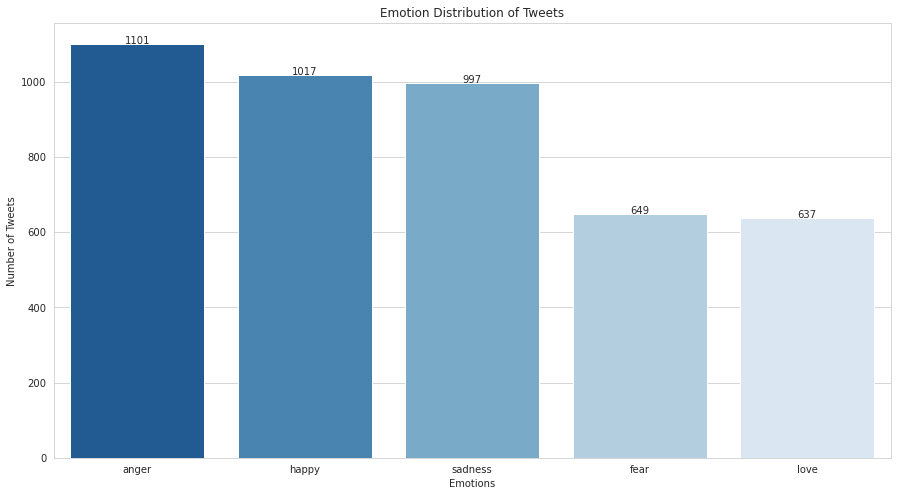

In [22]:
#data
labels=df['label'].value_counts().index
values=df['label'].value_counts().values

plt.figure(figsize = (15, 8))
plt.title('Emotion Distribution of Tweets')
plt.xlabel('Emotions')
plt.ylabel('Number of Tweets')
ax = sns.barplot(x=labels, y=values, palette=("Blues_r"))
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, values[i],ha="center")

In [23]:
df.to_csv('datasets/df_preprocessed.csv')